In [16]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import Neural_Net_Architectures as architecture
import Neural_Net_Helper_Classes as helper
import Neural_Net_Datasets as data

W/o Undersampling:
Training set: (2553918, 11)
Validation set: (547268, 11)
Test set: (547269, 11)
---------------------------------------------------

W/ Undersampling:
Training set: (1547761, 11)
Validation set: (331663, 11)
Test set: (331664, 11)


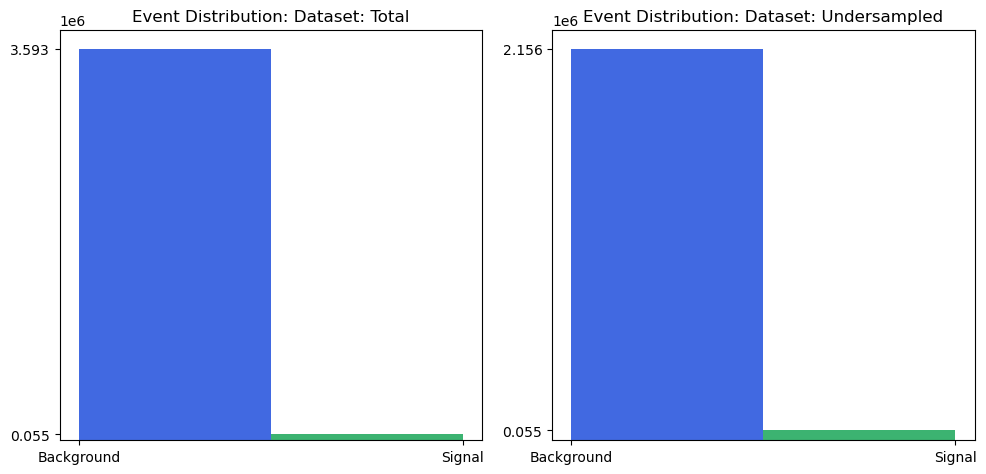

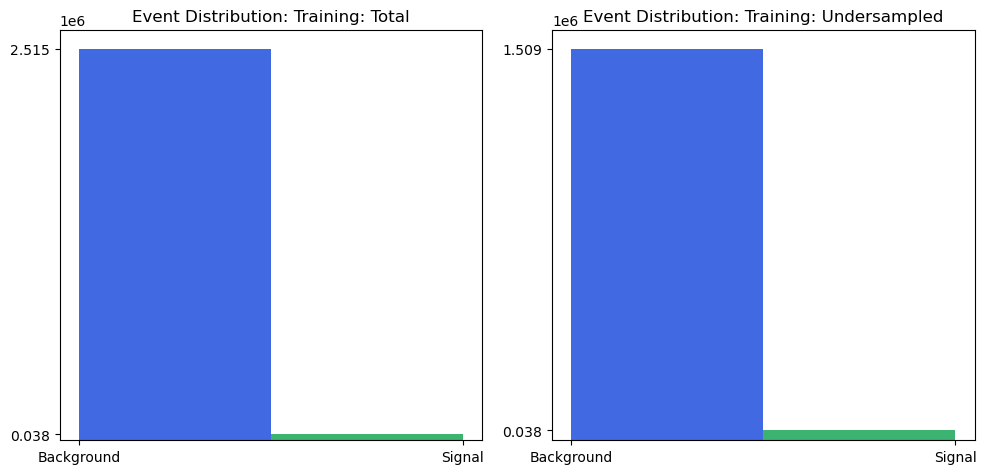

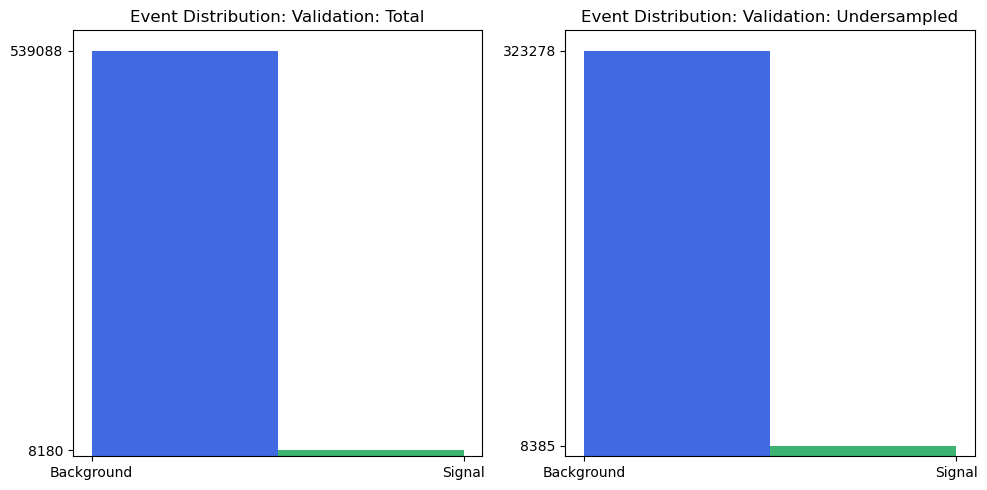

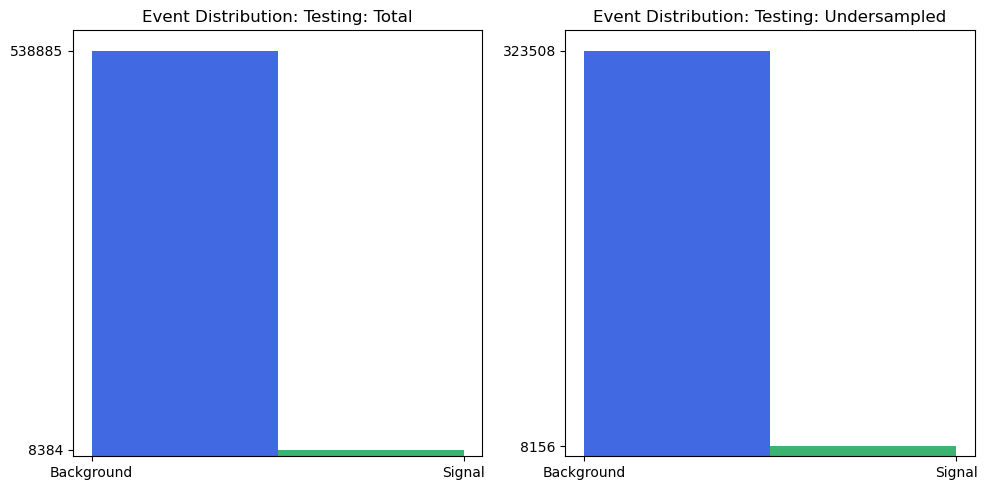

In [19]:
data_manipulator = data.DataManipulator(batch_size=32, transform=data.Normalize(), seed=7)

pickled_data_file_path = "transformed_data.pkl"
pickled_labels_file_path = "transformed_labels.pkl"
background_data_file_name = "train_bkg_data_sideBands_lowQ_wPreselBDT_v5.root"
signal_data_file_name = "train_sig_rare_lowQ_wPreselBDT_v6.root"

undersampling_ratio = 0.6
visualize = True

X, y = data_manipulator.load_all_data(pickled_X=pickled_data_file_path,
                                      pickled_y=pickled_labels_file_path,
                                      uproot_background=background_data_file_name,
                                      uproot_signal=signal_data_file_name)

data_manipulator.undersample_data(undersampling_ratio)
if visualize: data_manipulator.plot_all_compared_event_distributions()

X_train, X_val, X_test = data_manipulator.full_split_data
y_train, y_val, y_test = data_manipulator.full_split_labels

X_u_train, X_u_val, X_u_test = data_manipulator.undersampled_split_data
y_u_train, y_u_val, y_u_test = data_manipulator.undersampled_split_labels

In [3]:
loader = helper.ModelSaver()
results_builder = helper.ResultsBuilder()

shallow_narrow_model = loader.load_state_dict(model=architecture.ShallowNarrowModel(), filename="shallow_narrow_model_parameters.pth")
deep_narrow_model = loader.load_state_dict(model=architecture.DeepNarrowModel(), filename="deep_narrow_model_parameters.pth")
shallow_wide_model = loader.load_state_dict(model=architecture.ShallowWideModel(), filename="shallow_wide_model_parameters.pth")
deep_wide_model = loader.load_state_dict(model=architecture.DeepWideModel(), filename="deep_wide_model_parameters.pth")

models = [shallow_narrow_model, deep_narrow_model, shallow_wide_model, deep_wide_model]
model_names = {shallow_narrow_model: "Shallow/Narrow", deep_narrow_model: "Deep/Narrow", shallow_wide_model: "Shallow/Wide", deep_wide_model: "Deep/Wide"}

In [17]:
precisions, recalls, f1s, accuracies, cms = {}, {}, {}, {}, {}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for model in models:
    model.to(device)
    y_pred = model(torch.tensor(X_test, dtype=torch.float32))
    _, predicted = torch.max(y_pred, 1)
    y_pred = predicted.cpu().numpy()

    name = model_names[model]
    precisions[name] = precision_score(y_test, y_pred)
    recalls[name] = recall_score(y_test, y_pred)
    f1s[name] = f1_score(y_test, y_pred)
    accuracies[name] = accuracy_score(y_test, y_pred)
    cms[name] = confusion_matrix(y_test, y_pred)

/home/lucca/anaconda3/envs/ml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


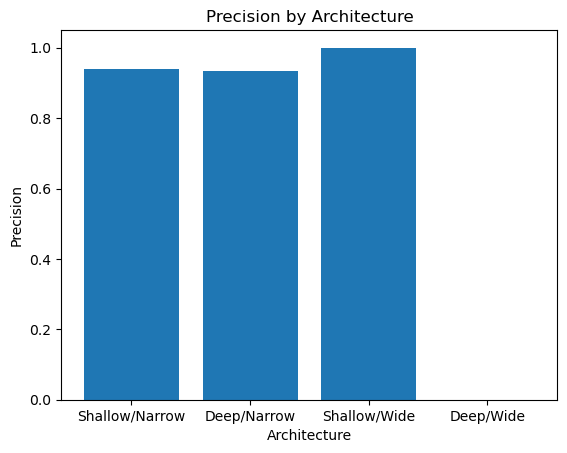

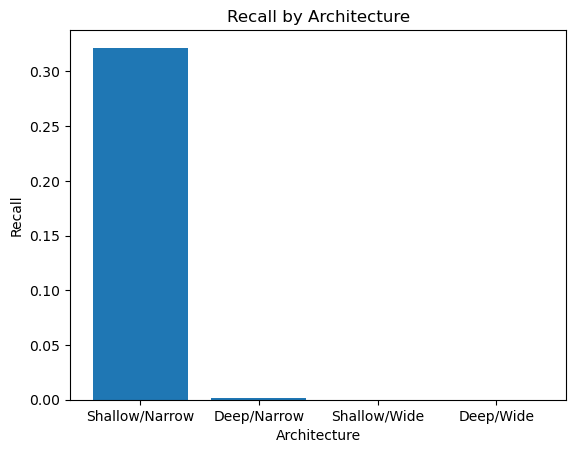

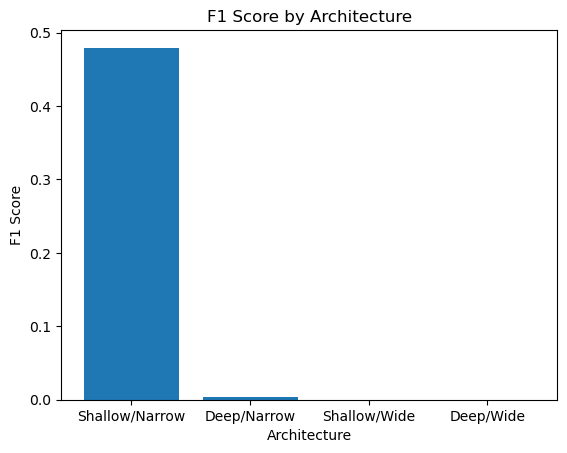

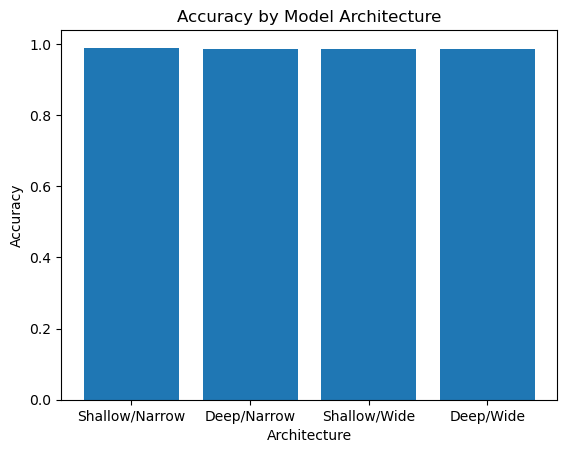

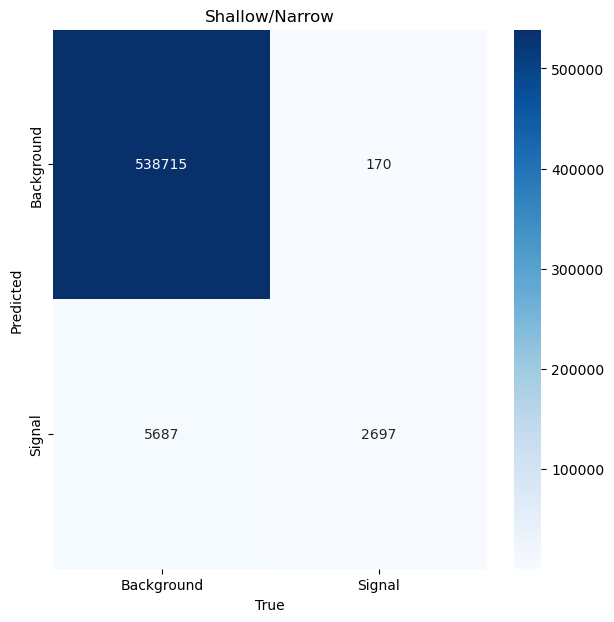

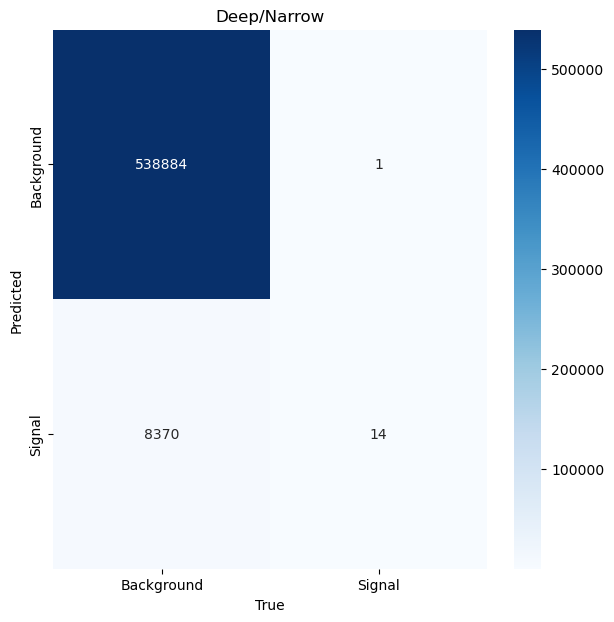

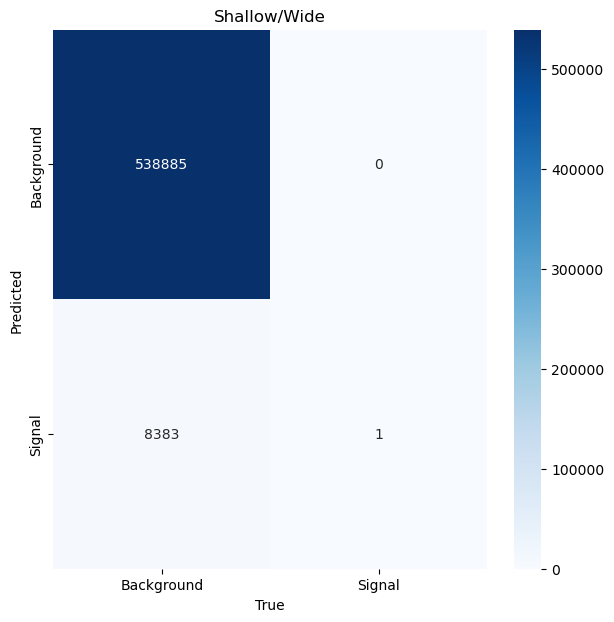

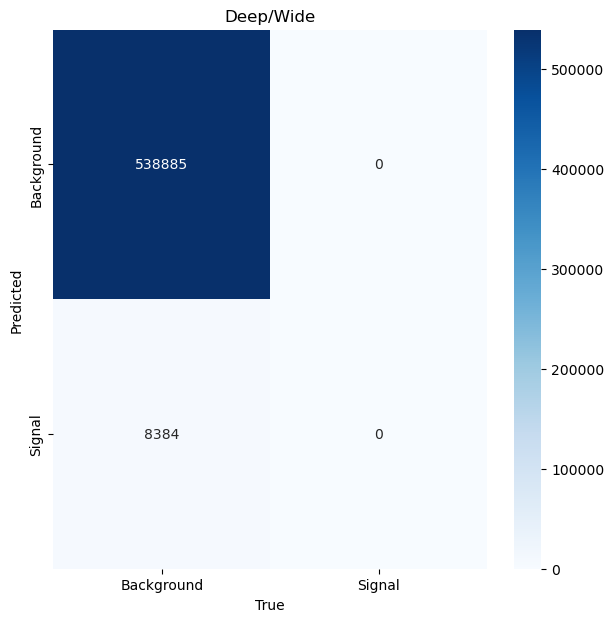

In [18]:
results_builder.plot_dictionary(precisions, "Architecture", "Precision", "Precision by Architecture")
results_builder.plot_dictionary(recalls, "Architecture", "Recall", "Recall by Architecture")
results_builder.plot_dictionary(f1s, "Architecture", "F1 Score", "F1 Score by Architecture")
results_builder.plot_dictionary(accuracies, 'Architecture', 'Accuracy', "Accuracy by Model Architecture")
for name, cm in zip(cms.keys(), cms.values()):
    results_builder.plot_confusion_matrix(cm, name)